In [1]:
# Uscita trigger dal signal generator: Pulse Sync

import sys
import numpy as np
sys.path.insert(1, 'C:\\Users\\oper\\SynologyDrive\\Lab2023\\Qubit\\QTLab2324\\PAandQubit\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, 'C:\\Users\\oper\\SynologyDrive\\Lab2023\\Qubit\\QTLab2324\\PAandQubit\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *


ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

Connection successful!


In [2]:
# parameters for the Signal Generator

f_min           = 10e6                                  # tryout value
f_max           = 50e6                                 # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e6)          # Set range of frequency of the signal to send to the resonator
amplitude       = -25                                   # Set the amplitude of the signal in dBm
pulse_width     = 2                                     # 2 microsec
pulse_delay     = 0

# parameters for the Acquisition Card
pxie.voltage_range = 2.0

pxie.coupling = 'AC' # or DC????
pxie.num_pts = 1000
pxie.num_records = 1
pxie.ref_position = 0

# set Signal Generator
sGen.reset()
sGen.clear()

sGen.RF_lvl_ampl(amplitude)
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')

sGen.pul_state(1)
sGen.RF_state(1)




In [3]:
pxie.open()

In [21]:
import time
slip = 0.0      # time of sleep of triggering

fetched_data = []

for i in pulse_freq:
    #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
    sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    sGen.pul_state(1)
    sGen.RF_state(1)
    time.sleep(0.01)
    wfm = pxie.acquisition(sGen.pul_exe_sing_trig,slip)
    sGen.pul_state(0)
    sGen.RF_state(0)
    fetched_data += [{'freq': i, 'data': wfm[0].samples.tolist()}]


AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
AcquisitionStatus.COMPLETE
A

freq: 11000000.0


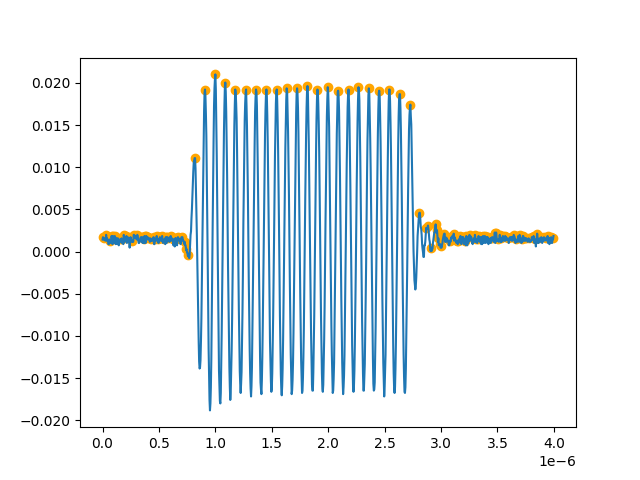

In [24]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
f_chosen = fetched_data[1]
print('freq:', f_chosen['freq'])
y = np.array(f_chosen['data'])
x = np.arange(len(y))/pxie.sample_rate

indices = find_peaks(y)

plt.clf()
plt.plot(x, y)
idx = indices[0]
plt.scatter(x[idx],y[idx], color = 'orange')

plt.show()

In [6]:
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
# %matplotlib widget

# x = np.linspace(0, 50*np.pi, 1000)      # ho messo numeri irrazionali perché confondevamo le x variabili con le posizioni (scegliendole intere coincidevano), dunque pensavamo di aver trovato i valori
# def fun(x):                             # e non gli indici. Quindi stavamo cercando gli indici tra gli stessi indici già trovati
#     return np.sin(x) * np.exp(-x/100)

# a = fun(x)

# plt.figure()
# plt.plot(a)
# plt.grid()

# fp = find_peaks(a)

# print(type(fp))                    # il problema è che fp è una tupla con dentro un array, una roba e un dizionario, non un array
# print(fp[0])                       # questo è l'array contenente gli indici dei massimi

# index = fp[0]

# for i in index:
#     print('position: ', i, '   x = ', x[i],  '   f(x) = ', a[i])
    

# # x e a sono due array di stessa lunghezza, quindi se find peakes trova le posizioni, basta poi stampare a[fp] e x[fp]
# # purché fp venga prima convertito in array





In [39]:
import h5py

          
with h5py.File('nonloso.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
    for j in range(0, len(fetched_data)):
        gp_data = f.create_group(str(j))
        freq, data = fetched_data[j].items()
        gp_data.create_dataset(str(freq[0]), data = freq[1])
        gp_data.create_dataset(str(data[0]), data = data[1])